
## Quantum Simulation in Imaginary Time for Gauge-Invariant Models: A Deterministic Approach for Imaginary-Time Evolution on Quantum Hardware  - *Theory and Foundations* (**A Review**)

### How to Read and Use This Notebook
This notebook is organized to give a somewhat thorough review to deterministic imaginary-time evolution (ITE) on quantum computers, a [framework developed by Daniele Cuomo.](https://zenodo.org/records/17092508)  
It is written to be rigorous yet accessible to students with basic quantum computing background.

As a deliverable for the Qiskit Advocate Methorship Program (QAMP), this notebook contains only the theoretical review of the framework. The experimental and Qiskit implementations, the actual project MVP for QAMP, are deferred to another notebook `ITE Implementation Notebook`.

---

### 1. What Is Imaginary Time Evolution (ITE)?

**Quick summary**: The fundamental law governing how quantum states change over time is the Schrödinger equation. Under normal conditions, quantum systems evolve unitarily, meaning their probabilities are conserved. This evolution is driven by the operator $U(t) = e^{-iHt}$, where $H$ is the Hamiltonian (total energy) of the system. This results in oscillatory behavior where quantum states rotate but do not naturally "settle" into their ground states. To find the ground state (the state of lowest energy), we could use a mathematical trick called a ["Wick rotation."](https://en.wikipedia.org/wiki/Wick_rotation) By replacing real time $t$ with imaginary time $t = -i\beta$ (where $\beta$ is a real number), the oscillatory Schrödinger equation transforms into a diffusion-like equation. Instead of rotating the state vector, Imaginary Time Evolution (ITE) *shrinks* the vector, decaying high-energy components faster than low-energy ones. This effectively "cools" the system down to its ground state.


So, Imaginary-time evolution (ITE) is a mathematical and physical procedure that allows us to systematically suppress high-energy components of a quantum state while retaining low-energy ones. As a result, it provides a natural mechanism for **finding ground states and thermal states of quantum systems**.  

Before discussing how ITE can be implemented on quantum hardware, it is essential to understand **what it is**, **where it comes from**, and **why it works**.

### 1.1 From Real-Time Evolution to Imaginary Time (Full Treatment)

In standard quantum mechanics, the time evolution of a closed quantum system is governed by the Schrödinger equation (setting $\hbar = 1$): 

$$i \frac{d}{dt} |\psi(t)\rangle = H |\psi(t)\rangle.$$

with solution $$|\psi(t)\rangle = e^{-i H t} |\psi(0)\rangle,$$

where the operator $U(t) = e^{-iHt}$ is **unitary**. Unitary implies that: 1. the norm of the quantum state is preserved, 2. the evolution corresponds to a *rotation* in the Hilbert space. 

As a result, real-time evolution **cannot preferentially select low-energy states**. It merely moves probability amplitudes around while conserving total probability. However, knowing the ground state is essential and a central goal of many quantum algorithms.

In physics and chemistry, a system at absolute zero naturally settles into its ground state (the state of lowest possible energy). Knowing this state allows us to predict the stable configurations of molecules, the rates of chemical reactions, and the phases of novel materials (like superconductors). 

In quantum computing, hard computational tasks—such as the Traveling Salesperson Problem or financial portfolio optimization can be mapped onto physics problems. By encoding the "cost" of a problem as the energy of a Hamiltonian, finding the optimal solution is equivalent to finding the quantum ground state. Because the dimension of the quantum state space grows exponentially with the number of particles, classical computers fail at this task. Thus, finding the ground state efficiently is a major benchmark for quantum advantage.

Now consider replacing the real time variable in the evolution operator $U(t)$ with an *imaginary* one via a [Wick rotation](https://en.wikipedia.org/wiki/Wick_rotation):

$$t \;\longrightarrow\; -i\beta, \quad \beta \in \mathbb{R}^+. $$

Under this transformation, the time-evolution operator becomes

$$|\psi(\beta)\rangle = e^{-\beta H} |\psi(0)\rangle.$$

Unlike real-time evolution, this operator is not unitary. Instead of rotating the state, it selectively damps certain components of the wavefunction. This simple substitution fundamentally changes the physics of the evolution, as will be decribed below.

### 1.2 Eigenbasis Picture: Why ITE Favors Low Energy States

To see what imaginary-time evolution actually does, it is best to work in the eigenbasis of the Hamiltonian. Let

$$H = \sum_n E_n |E_n\rangle \langle E_n|, \quad E_0 < E_1 < E_2 \dots $$

be the spectral decomposition of the Hamiltonian with energy eigenstates $|E_{n}\rangle$, and energy eigenvalues $E_{n}$. An arbitrary initial state can always be written as

$$|\psi(0)\rangle = \sum_n c_n |E_n\rangle, \quad c_n = \langle E_n | \psi(0) \rangle.$$

Applying imaginary-time evolution operator $e^{-\beta H}$ gives

$$|\psi(\beta)\rangle = \frac{e^{-\beta H} |\psi(0)\rangle}{\sqrt{\langle \psi(0)| e^{-2\beta H}|\psi(0)\rangle}}  = \frac{1}{N(\beta)} \sum_n c_n e^{-\beta E_n} |E_n\rangle,$$

where $N(\beta)$ is the normalization factor since $e^{-\beta H}$ is non-unitary. 

At this stage, nothing mysterious has happened: each energy eigenstate simply picks up a real exponential factor. However, the key observation is that these factors depend on the energy. To make this explicit, let's factor out the ground-state energy decay rate contribution, $e^{-\beta E_{0}}$:

$$|\psi(\beta)\rangle = \frac{e^{-\beta E_0}}{N(\beta)} \left(c_0 |E_0\rangle + \sum_{n>0} c_n e^{-\beta (E_n - E_0)} |E_n\rangle \right).$$

Since $(E_{n} - E_{0} > 0)$ for all excited states ($n > 0$), the exponent $- (E_{n} - E_{0})$ is strictly negative. As the imaginary time increases (as $\beta \to \infty$), the exponential factors $e^{-\beta (E_n - E_0)}$ decay rapidly to zero:

$$\lim_{\beta \to \infty} e^{-(E_n - E_0)\beta} = 0.$$

Therefore, the system purely projects onto the ground state (which we desire):

$$\lim_{\beta \to \infty} |\psi(\beta)\rangle = |E_0\rangle, \quad \text{provided } c_0 \neq 0.$$

To visualize ITE to see how the system projects onto the ground state, we can simulate it on a **simple** 2-level quantum system (a single qubit). Let's define a simple Hamiltonian for a qubit in a magnetic field of unit strength and energy offset: 

$$ H = 2I + Z + X.$$

Assuming the initial state of the system is 

$$ |\psi(0)\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}},$$

we can check what state the system is in after some time $\beta$, and also what the amplitude of each possible state is at such time.

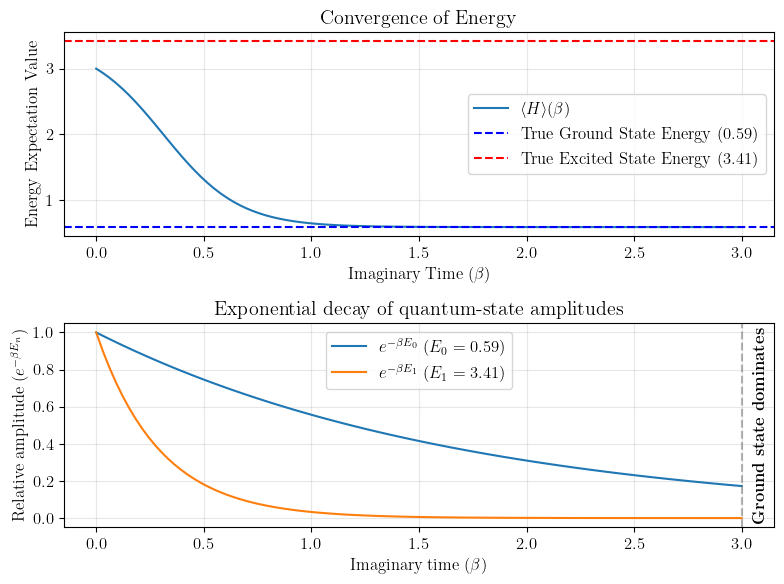

In [ ]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

# latex fonts
plt.rcParams.update({
    'text.usetex' : True,
    'font.family': 'serif',
    'font.serif':['Computer Modern Roman'],
    'font.size': 12,

    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{bm}',
})

# Define the Pauli Matrices and Hamiltonian
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
Id = np.array([[1, 0], [0, 1]])

# H = Z + 0.5 * X
H = 2*Id + Z + X

# Calculate exact eigenvalues to find the true ground state energy
eigenvalues, eigenvectors = np.linalg.eigh(H)
true_gs_energy = eigenvalues[0]

# Define an arbitrary initial state |psi(0)> (e.g., |+> state)
psi_0 = np.array([1, 1]) / np.sqrt(2)

# Simulate Imaginary Time Evolution
beta_values = np.linspace(0, 3, 100)
energies = []

for beta in beta_values:
    # Apply the non-unitary operator e^(-H*beta)
    evolution_op = linalg.expm(-H * beta)
    psi_beta_unnormalized = evolution_op @ psi_0
    
    # Re-normalize the state
    norm = np.linalg.norm(psi_beta_unnormalized)
    psi_beta = psi_beta_unnormalized / norm
    
    # Calculate expectation value: <psi|H|psi>
    energy = np.real(np.vdot(psi_beta, H @ psi_beta))
    energies.append(energy)

# Plot the results
plt.figure(figsize=(8, 6))
ax = plt.subplot(2, 1, 1)
plt.plot(beta_values, energies, label=r'$\langle H \rangle (\beta)$')
plt.axhline(y=true_gs_energy, color='blue', linestyle='--', label=f'True Ground State Energy ({true_gs_energy:.2f})')
plt.axhline(y=eigenvalues[1], color='red', linestyle='--', label=f'True Excited State Energy ({eigenvalues[1]:.2f})')
plt.title("Convergence of Energy")
plt.xlabel(r"Imaginary Time ($\beta$)")
plt.ylabel("Energy Expectation Value")
plt.legend()
plt.grid(True, alpha=0.3)

# Compute decaying amplitudes 
amplitudes = np.exp(-np.outer(eigenvalues, beta_values))  # shape (len(eigenvalues), len(tau))

# Plot amplitudes
ax = plt.subplot(2, 1, 2)
for n, En in enumerate(eigenvalues):

    plt.plot(beta_values, amplitudes[n], label=fr"$e^{{-\beta E_{n}}}$  ($E_{n}={En:.2f}$)")

# Highlight region of strong ground-state dominance
plt.axvline(3, color='gray', linestyle='--', alpha=0.6)
plt.text(3.05, 0.5, r"\textbf{Ground state dominates}", rotation=90, va='center', color='black')

# Labels and formatting
plt.xlabel(r"Imaginary time ($\beta$)")
plt.ylabel(r"Relative amplitude (${e^{-\beta E_n }}$)")
plt.title(r"Exponential decay of quantum-state amplitudes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

From the two plots above, we see that under ITE, as imaginary time increases, the system naturally “settles” into its lowest-energy configuration. Even if the initial state is a complicated superposition, imaginary-time evolution continuously damps higher-energy contributions until only the ground state remains.

This behavior is the **core reason** imaginary-time evolution is so powerful:
- it does not require guessing the ground state,
- it does not require diagonalizing the Hamiltonian,
- it works for *any* initial state with nonzero ground-state overlap.

### 1.3 The Quantum Computing Challenge: Non-Unitary Evolution

Imaginary-time evolution is extremely powerful from a theoretical and numerical standpoint. However, translating it into a quantum circuit is far from straightforward. In section 1.2, we saw that the ITE operator $U(\beta) = e^{-\beta H}$ cools the system to the ground state. So, why can't we simply implement this operator on a quantum computer and be done? The fundamental constraint of quantum hardware is that all quantum gates must be unitary. A unitary operator U preserves the total probability of the quantum state, mathematically defined as $U^{\dagger}U=I$ (where $I$ is the identity matrix and $\dagger$ represents the conjugate transpose). However, for ITE operator 

$$U^{\dagger}U = (e^{-\beta H})^{\dagger}(e^{-\beta H}) = (e^{-2\beta H}) \neq I,$$

since the Hamiltonian $H$ is Hermitian ($H^{\dagger} = H$). Because $e^{-2\beta H}$ is not the identity matrix, the operation does not preserve probability amplitudes and inner products. It corresponds to shrinking the state vector (to isolate the ground state), which violates the laws of standard quantum gate operations. Therefore, we cannot directly program an ITE gate. We must find clever ways to approximate this non-unitary operation using only unitary gates (that preserve state norms). 

To overcome this limitation, over the past several years, researchers have developed three major mathematical frameworks, each making different compromises between accuracy, efficiency, and scalability. Understanding their mechanics and their severe limitations is crucial to appreciating the modern probabilistic approach we will later implement (** this main project **).

### 1.4 Variational Imaginary-Time Evolution (VITE) [1, 2, 3]

VITE adapts the principles of variational quantum algorithms to the imaginary time domain by approximating imaginary-time dynamics on quantum hardware. The core strategy is to restrict the evolution to a parameterized familty of trial states that can be easily prepared on a quantum computer. Instead of applying the exact operator $e^{-H\beta}$, we guess a parameterized quantum circuit in trial state $|\psi(\vec{\theta})\rangle$ (the ansatz) whose parameters are updated to best follow imaginary-time evolution within this restricted manifold. We then minimize the distance between the exact evolution and our variational approximation:

$$\delta || \left( \frac{\partial}{\partial \beta} + H \right) |\psi(\vec{\theta})\rangle ||^2 = 0$$

Solving this minimization leads to a system of differential equations known as the **McLachlan Equations of Motion**:
$$\sum_j A_{ij} \dot{\theta}_j = -C_i.$$

Here, the matrix $A_{ij} = \text{Re}(\langle \partial_i \psi | \partial_j \psi \rangle)$ is the real part of the **Quantum Geometric Tensor** (or an equivalent metric tensor on the variational manifold), which describes how the quantum state changes with parameters and $C_i = -\text{Re}(\langle \partial_i \psi | H | \psi \rangle)$ encodes the energy gradients. Both quantities are estimated from expectation values measured on the quantum device, while the resulting linear system is solved classically.

From a practical standpoint, VITE has several attractive features. It relies exclusively on unitary quantum circuits, making it compatible with near-term quantum hardware, and it naturally fits within the hybrid quantum–classical paradigm of variational algorithms. However, these advantages come with fundamental limitations. Most importantly, VITE is inherently approximate. The imaginary-time dynamics are enforced only within the chosen variational subspace, and the quality of the approximation depends critically on the expressiveness of the ansatz. Convergence is therefore guaranteed only to the best approximation of the target state *within the variational family*, not necessarily to the true ground state or thermal state of the Hamiltonian.

Crucially, VITE does not implement imaginary-time evolution as a physical quantum channel. Instead, it replaces the non-unitary dynamics generated by $e^{-\beta H}$ with variational motion constrained to a finite-dimensional manifold of states. This distinction is essential when comparing VITE to approaches that aim to realize imaginary-time evolution more directly at the circuit level. Also, to update the parameters, the classical computer must invert the matrix $A$. However, measuring $A_{ij}$ on quantum hardware introduces statistical noise (shot noise). Because $A$ is often nearly singular (ill-conditioned), inverting a noisy matrix leads to wildly unstable and inaccurate parameter updates, derailing the algorithm.

### 1.5 Quantum Imaginary-Time Evolution (QITE) [4]

Unlike VITE, which restricts the physics to a predefined variational manifold, QITE attempts to approximate imaginary-time evolution by locally replacing non-unitary operators with unitary ones. The starting point is the formal imaginary-time evolution over a small step $\Delta\beta$,

$$ e^{-\Delta\beta H} \approx e^{-\Delta\beta \sum_j h_j}, $$

where the Hamiltonian is decomposed into local terms $h_j$. For each term, QITE aims to approximate the action of the non-unitary operator $e^{-\Delta\beta h_j}$ by a unitary operator of the form

$$e^{-i \Delta\beta A_j},$$

where $A_j$ is a Hermitian operator supported on a local subsystem. The operator $A_j$ is chosen such that the unitary evolution reproduces the effect of imaginary-time evolution on a restricted set of local observables.

This approximation is justified by the observation that, for sufficiently small $\Delta\beta$ and short correlation lengths, the effect of imaginary-time evolution can be captured locally. The coefficients defining $A_j$ are obtained by solving a linear system whose entries are expectation values of local operators measured on the quantum device. From a conceptual standpoint, QITE replaces non-unitarity with local unitary dynamics, trading exact imaginary-time evolution for an approximation that preserves locality. This makes the method compatible with unitary-only quantum circuits and avoids the need for postselection or probabilistic steps.

However, QITE also faces intrinsic limitations. As imaginary-time evolution progresses, correlations typically grow, increasing the size of the local subsystems required to accurately approximate the dynamics. This leads to rapidly increasing measurement overhead and classical post-processing costs. In practice, the method becomes inefficient when long-range correlations or critical behavior are present.

In contrast to variational approaches, QITE does not rely on a fixed ansatz. At the same time, it does not implement imaginary-time evolution as a physical quantum channel. Instead, it constructs a **local, step-by-step unitary approximation** whose accuracy is controlled by correlation length and subsystem size. This fundamental trade-off distinguishes QITE from both variational methods and from measurement-based approaches that explicitly realize non-unitary dynamics.

### 1.6 Probabilistic and Measurement-Based Imaginary-Time Approaches

A third broad class of approaches to quantum imaginary-time evolution embraces non-unitarity directly by introducing measurements, randomness, or postselection. Rather than attempting to approximate imaginary-time evolution using only unitary dynamics, these methods exploit the fact that measurement-induced state updates are intrinsically non-unitary. At a high level, the strategy is to embed the system of interest into a larger Hilbert space by introducing ancillary degrees of freedom, apply a joint unitary evolution, and then perform measurements on the ancillas. Conditioned on the measurement outcomes, the system undergoes an effective non-unitary transformation that can approximate the action of $e^{-\beta H}$.

Formally, this can be viewed as implementing imaginary-time evolution through a quantum channel described by Kraus operators $\{ M_k \}$, where

$$\rho \;\longrightarrow\; \sum_k M_k \rho M_k^\dagger,$$

and the Kraus operators are engineered so that the channel reproduces the desired imaginary-time dynamics, up to normalization. In many early proposals, this procedure relied on **postselection**: only runs in which a particular measurement outcome occurs are kept, while all others are discarded. While mathematically sound, this approach suffers from a severe practical limitation. The probability of successful postselection typically decreases exponentially with system size and with the total imaginary time $\beta$, rendering the method inefficient for realistic problems.

Other stochastic approaches introduce randomness through auxiliary-field decompositions or probabilistic sampling of non-unitary operators. Although these methods avoid explicit postselection, they often encounter a **sign problem**: different stochastic trajectories contribute with fluctuating signs or weights, leading to large variances and poor scaling with system size.

The unifying feature of these approaches is that they successfully capture non-unitary dynamics, but only at the cost of either:
- exponentially small success probabilities,
- rapidly growing statistical noise,
- or substantial classical post-processing overhead.

As a result, while probabilistic and measurement-based methods demonstrate that imaginary-time evolution can, in principle, be realized on quantum hardware, they do not provide a scalable or deterministic route to computing thermal observables.

This observation sets the stage for the central question addressed by Cuomo’s framework:

> *Can measurement-induced non-unitarity be used to implement imaginary-time evolution in a way that is probabilistic at the circuit level, yet deterministic at the level of physical observables?*

### 1.7 Transition to Cuomo's Framework

Despite the mechanical differences of the previously mentioned quantum imaginary-time methods, they share several features: 

- They avoid directly implementing non-unitary evolution.
- They rely on approximations, either variational or local.
- They introduce significant classical overhead.
- They do not exploit deeper structural properties of the Hamiltonian.

Most importantly, they treat non-unitarity as a problem to be circumvented, rather than something to be harnessed carefully. Consequently, each method faces a fundamental bottleneck; be it ansatz bias, correlation limits, or signal-to-noise ratio -- that prevents scalable, deterministic imaginary time evolution.

This landscape leaves a clear gap for a method that is deterministic, exact, and global. The framework we explore next, developed by [Cuomo](https://zenodo.org/records/17092508), achieves this by rethinking the role of measurement. Instead of discarding "wrong" outcomes, it uses Gauge Invariance to prove that every measurement outcome contributes valid physical information about the ground state. By entangling the system with an extra qubit and measuring it, the wave function "collapses." This collapse is a naturally non-unitary process provided by quantum mechanics itself, allowing us to step forward in imaginary time probabilistically, but with high algorithmic control.

In the next section, we introduce the core idea of deterministic imaginary-time circuits, which directly addresses the shortcomings discussed here.

---
**References**
1. [Yuan, X., et al. "Theory of variational quantum simulation." *Quantum* 3 (2019): 191.](https://web.archive.org/web/20200207191007id_/https://quantum-journal.org/papers/q-2019-10-07-191/pdf/)
2. [McArdle, S., et al. "Variational ansatz-based quantum simulation of imaginary time evolution." *npj Quantum Information* 5.1 (2019): 1-6.](https://www.nature.com/articles/s41534-019-0187-2)
3. [J. McLachlan, *A variational solution of the time‐dependent Schrödinger equation*, Mol. Phys. **8**, 39 (1964).](https://www.tandfonline.com/doi/abs/10.1080/00268976400100041)
4. [Motta, M., et al. "Determining eigenstates and thermal states on a quantum computer using quantum imaginary time evolution." *Nature Physics* 16.2 (2020): 205-210.](https://www.nature.com/articles/s41567-019-0704-4) 



## **PART II — The Cuomo Framework: From Theory to Implementation**

---

### **2.1 Thermal Physics: Density Matrix Perspective and Thermal States**

In Part I, we focused on finding the ground state of an Hamiltonian. This corresponds to the limit of zero temperature ($T \to 0$ or $\beta \to \infty$). However, to understand real-world quantum systems—such as materials at room temperature or noisy quantum hardware, we must extend our framework to finite temperatures.

At a finite inverse temperature $\beta = 1/(k_{B}T)$, a quantum system is not described by a single wavefunction (a pure state), but by a statistical ensemble known as a density matrix, $\rho$. The equilibrium state is given by the Gibbs distribution:

$$ \rho(\beta) = \frac{e^{-\beta H}}{Z(\beta)}$$

where $Z(\beta)$ = $\text{Tr}(e^{-\beta H})$ is the partition function. To To calculate the expectation value of any observable ($\hat{O}$) (like energy or magnetization), we must compute the trace:

$$\langle \hat{O} \rangle_\beta = \text{Tr}(\rho(\beta) \hat{O}) = \frac{\text{Tr}(e^{-\beta H} \hat{O})}{\text{Tr}(e^{-\beta H})}$$

Just as some algorithms start with an "easy" state (like $|00...0\rangle$) and evolve it, thermal algorithms can also start with an "easy" density matrix. The most natural starting point is **Infinite Temperature** ($\beta = 0$).
Mathematically, substituting $\beta = 0$ into the Gibbs state yields the identity matrix (normalized):

$$\rho(0) \propto e^{-0 \cdot H} = \frac{I}{\dim \mathcal{H}}$$

This is called the **maximally mixed state**.

At infinite temperature, thermal fluctuations are so dominant that the system is equally likely to be in any energy state. All coherence is washed out. This state is completely unbiased. It contains no information about the Hamiltonian's specific interactions. By starting at $\beta=0$ and slowly increasing $\beta$ (cooling the system), we can smoothly transform this featureless identity state into the specific thermal state of the target Hamiltonian.

How do we create a "mixed" state like $\rho \propto I$ on a quantum computer that inherently uses pure state vectors? We use a technique called **Purification**.

The maximally mixed state $\rho_S = I/\dim \mathcal{H}$ on a system $S$ can be generated by preparing a maximally entangled pure state on a larger space $S \otimes A$ (where $A$ is an auxiliary system) and tracing out $A$.

**Proof:**

1.  Consider a system $S$ of $N$ qubits (dimension $\dim \mathcal{H} = d =2^N$). We introduce a duplicate set of $N$ auxiliary qubits, labeled $A$.
2.  Prepare the composite system in a **Maximally Entangled State** (a product of $N$ Bell pairs):
    
    $$|\Phi\rangle_{SA} = \frac{1}{\sqrt{d}} \sum_{k=0}^{d-1} |k\rangle_S \otimes |k\rangle_A$$
    
3.  The density matrix of the total pure state is:

    $$\rho_{SA} = |\Phi\rangle_{SA} \langle\Phi|_{SA} = \frac{1}{d} \sum_{j,k} (|j\rangle_S \otimes |j\rangle_A)(\langle k|_S \otimes \langle k|_A)$$

4.  To find the state of the system $S$ alone, we perform the **partial trace** over the auxiliary register $A$:

    $$\rho_S = \text{Tr}_A(\rho_{SA}) = \sum_{m} \langle m|_A (\rho_{SA}) |m\rangle_A$$

5.  Substituting the expansion from step 3:

    $$\rho_S = \frac{1}{d} \sum_{j,k} |j\rangle_S \langle k|_S \underbrace{\left( \sum_m \langle m|_A j\rangle_A \langle k|_A m\rangle_A \right)}_{\text{Orthogonality check}}$$

    The term in the bracket is non-zero only if $j = m$ and $k = m$. Therefore, $j$ must equal $k$.
6.  The summation collapses to:
    $$\rho_S = \frac{1}{d} \sum_{k=0}^{d-1} |k\rangle_S \langle k|_S$$
    Since $\sum_k |k\rangle\langle k|$ is the completeness relation (the sum of outer products of a basis is the identity), we arrive at:
    $$\rho_S = \frac{I_S}{d}$$

Therefore, we do not need to simulate noise to create a thermal state. We simply prepare $N$ pairs of perfectly entangled qubits. By acting on the system qubits with our imaginary time evolution circuit and leaving the ancilla qubits alone, we are effectively cooling the system from infinite temperature ($\beta=0$) to finite temperature, while the entanglement tracks the entropy.

Before we start building circuits, and as a sanity check, we need to confirm that our mathematical intuition holds up. The claim is that applying Imaginary Time Evolution to the Maximally Mixed state produces a thermal Gibbs state (and thermal ensembles). we can verify this analytically.

In imaginary time, a density matrix $\rho$ evolves according to the non-unitary transformation:

$$\rho(\beta) = \frac{e^{-H\beta} \rho(0) e^{-H\beta}}{\text{Tr}(e^{-H\beta} \rho(0) e^{-H\beta})}$$

  
1.  Let our initial state be the maximally mixed state we just prepared:

    $$\rho(0) = \frac{I}{d}$$

    *(where $d$ is the dimension of the system).*

2.  Substitute $\rho(0)$ into the evolution equation. Since the Identity matrix $I$ commutes with everything ($e^{-H\beta} I = e^{-H\beta}$), we get:

    $$\rho(\beta) = \frac{e^{-2\beta H}}{\mathrm{Tr}(e^{-2\beta H})}.$$

3.  This result is exactly a Gibbs (thermal) state at inverse temperature $2 \beta$.

So, this simple derivation tells us that Imaginary Time Evolution is not just a tool for finding ground states. It is a natural engine for **Thermodynamics**.

In summary:

- imaginary-time evolution is not just about ground states,
- it naturally produces thermal ensembles,
- expectation values computed from $\rho(\beta)$ correspond to thermodynamic averages.



### 2.2 The Algorithmic Engine: Auxiliary Qubits, Trotterization, and Finite Imaginary-Time Steps

The goal of Cuomo’s framework is to implement imaginary-time evolution generated by a Hamiltonian of the form

$$ H = \sum_j \alpha_j P_j, \qquad P_j \in \{I,X,Y,Z\}^{\otimes n},$$

using quantum circuits composed exclusively of unitary gates, auxiliary qubits, and measurements. Since the Pauli terms $P_j$ generally do not commute, the imaginary-time evolution operator cannot be implemented exactly in a single step. Instead, the evolution is approximated through a controlled sequence of finite steps using Trotterization.

The imaginary-time evolution operator is defined as

$$ e^{-\beta H} = e^{-\beta \sum_j \alpha_j P_j}. $$

For non-commuting terms, this operator is approximated using a first-order Trotter–Suzuki decomposition,

$$ e^{-\beta H} \approx \left(\prod_j e^{-\Delta\beta\, \alpha_j P_j}\right)^N + \mathcal{O}(\Delta\beta^2), \qquad \beta = N\,\Delta\beta. $$

Here:

- $\Delta\beta$ is a **small imaginary-time step**,
- $N$ is the number of Trotter steps,
- each factor $e^{-\Delta\beta\, \alpha_j P_j}$ is implemented independently.

This decomposition is essential because Cuomo’s algorithm provides a circuit-level implementation of individual Pauli exponentials, not of the full Hamiltonian in one operation.

Each Pauli string satisfies

$$ P_j^2 = I. $$

As a result, the exponential of a Pauli operator has the exact closed-form expression

$$ e^{-\Delta\beta\, \alpha_j P_j} = \cosh(\alpha_j \Delta\beta)\, I - \sinh(\alpha_j \Delta\beta)\, P_j.$$

This expression further highlights that imaginary-time evolution is **non-unitary**. The hyperbolic functions $\cosh$ and $\sinh$ generate a contraction toward low-energy states, rather than a norm-preserving rotation.

The problem is therefore reduced to the following:

- How can a quantum circuit implement an operator proportional to  
- $\cosh(\lambda) I - \sinh(\lambda) P$,  
- using only unitary gates and measurements?

where $\lambda = \alpha_j \Delta\beta$.

Thus, to implement the ITE on a quantum computer, we must construct a circuit that reproduces the hyperbolic functions coefficients using trigonometric gates. 

To perform this non-unitary step, consider a system register $S$ and a single auxiliary qubit $A$, initially prepared in the state $|0\rangle_A$. We apply a specific unitary interaction $U(\theta)$ that entangles the systema and the ancilla:

$$ U = e^{-i \theta\, P_j \otimes Y_A},  $$

where $Y_A$ is the Pauli-$Y$ operator acting on the auxiliary qubit and $\theta$ is a tunable rotation angle. 

After applying $U$, the auxiliary qubit is measured in the computational basis. The effective measurement operators acting on the system are

$$ M_0 = \langle 0|_A\, U\, |0\rangle_A, \qquad M_1 = \langle 1|_A\, U\, |0\rangle_A.$$

A direct calculation yields

$$ M_0 = \cos(\theta)\, I - \sin(\theta)\, P_j, \qquad M_1 = \cos(\theta)\, I + \sin(\theta)\, P_j.$$

Thus, conditioned on the measurement outcome, the system undergoes a **non-unitary transformation** proportional to either

$$ I \pm P_j. $$

The sign depends on the classical measurement result of the auxiliary qubit.

Now, we must choose the circuit angle $\theta$ so that the hardware operators ($M_{0,1}$) must match the physical target ($e^{-\lambda P}$). Comparing the coefficients:

- Target: $\cosh{(\lambda) I} - \sinh{(\lambda) P}$
- Hardware: $\cos{(\theta) I} - \sin{(\theta) P}$

We need the ratio of the coefficients to match:

$$ \tan{(\theta)} = \frac{\sin{(\theta)}}{\cos{(\theta)}} = \frac{\sinh{(\lambda)}}{\cosh{(\lambda)}} = \tanh{(\lambda)}.$$

Solving for $\theta$

$$ \theta = \arctan({\tanh{(\lambda)}}).$$

Identifying the trigonometric coefficients with the hyperbolic coefficients appearing in the exact exponential, $\cos{(\theta)}$ and $\cosh{(\lambda)}$ are not equal but only proportional

$$ \cos(\theta) \propto \cosh(\lambda), \qquad \sin(\theta) \propto \sinh(\lambda), \qquad \lambda = \alpha_j \Delta\beta.$$

The circuit introduces a normalization factor (a probability of success) achieved by defining

$$ \cos(\theta) = \frac{\cosh(\lambda)}{\sqrt{\cosh^2(\lambda) + \sinh^2(\lambda)}}, \qquad \sin(\theta) = \frac{\sinh(\lambda)}{\sqrt{\cosh^2(\lambda) + \sinh^2(\lambda)}}.$$

Using the identity

$$ \cosh^2(\lambda) + \sinh^2(\lambda) = \cosh(2\lambda), $$

we obtain

$$ \sin^2(\theta) = \frac{\sinh^2(\lambda)}{\cosh(2\lambda)}. $$

For this to remain a valid probability (i.e., $\le 1$), and for the mapping $\theta = \arctan({\tanh{(\lambda)}})$ to be real and stable, $\theta$ must lie within a finite range so the rotation is not pushed too far. In practice, the circuit construction is chosen such that

$$ |\theta| \le \frac{\pi}{4}, $$

which guarantees that both $\cos(\theta)$ and $\sin(\theta)$ are real, non-negative, and bounded away from zero. This condition translates directly into the constraint

$$ |\alpha_j \Delta\beta| \le \frac{\pi}{4}. $$

The bound applies to the **product** $\alpha_j \Delta\beta$, not to the total inverse temperature $\beta$.

This distinction is essential:

- The total imaginary time $\beta$ may be arbitrarily large.
- Large $\beta$ is achieved by increasing the number of Trotter steps $N$.
- Each individual step must satisfy 

  $$ |\alpha_j \Delta\beta| \le \frac{\pi}{4}. $$

Imaginary-time evolution is therefore implemented as a **sequence of small, controlled non-unitary transformations**, each of which corresponds to a physically realizable measurement process.

Each measurement produces one of two operators,

$$ M_\pm \propto \cosh(\lambda)\, I \pm \sinh(\lambda)\, P_j, $$

corresponding to imaginary-time evolution under either $+\alpha_j P_j$ or $-\alpha_j P_j$.

At the level of individual circuit executions, this introduces randomness. However, the resulting Hamiltonians differ only by local Pauli sign transformations. These transformations correspond to gauge symmetries that leave spectra, partition functions, and thermal expectation values invariant.

As a result, although the circuit dynamics are probabilistic, the physical quantities computed by the algorithm are deterministic.

The next section formalizes why these probabilistic sign changes do not alter physical observables, through the principle of **gauge invariance**.

### Quick Hardware Implementation Note

In above, we used an $R_y(\theta)$ gate on the auxiliary qubit because it is mathematically intuitive—it directly sets up the cosine/sine weights. However, in actual hardware implementations, you will often see a different sequence of gates involving **Hadamards ($H$)** and **$\sqrt{X}$** gates.

Real superconducting quantum processors often do not have a native $R_y$ gate. Instead, they typically support:
1.  **Z-rotations**, and
2.  **X-pulses**.

To implement the required operation using these native gates, we rely on a standard matrix identity that decomposes a Y-rotation into X and Z rotations:

$$R_y(\theta) \equiv R_x(\pi/2) R_z(\theta) R_x(-\pi/2)$$

In the Cuomo framework, the circuit is often compiled as:
1.  **Hadamard ($H$):** Initializes the ancilla in $|+\rangle$.
2.  **Controlled-Interaction:** Entangles the system and ancilla (often a Controlled-Phase or Controlled-$R_z$).
3.  **$\sqrt{X}$ (or $R_x(\pi/2)$):** Rotates the basis before measurement.

Therefore, the appearance of $Z, H, \sqrt{X}$ gates in the implementation reflects a change of basis dictated by hardware constraints; the resulting circuit is unitarily equivalent to the theoretical $P \otimes Y$ construction and induces the same measurement-conditioned quantum channel. 


### 2.3 Gauge Invariance: Cuomo's Framework

As shown in the previous section, each imaginary-time Trotter step involves a measurement on an auxiliary qubit, and the outcome of that measurement determines which non-unitary operator is applied to the system. As a result, individual circuit executions introduce stochastic sign changes in the effective system Hamiltonian. At first glance, this randomness appears problematic: imaginary-time evolution is meant to deterministically project a system toward low-energy states, yet the circuit seemingly applies different Hamiltonians on different runs. The resolution of this apparent contradiction lies in the concept of **gauge invariance**.

Consider a Hamiltonian written as a sum of Pauli strings,

$$ H = \sum_j \alpha_j P_j . $$

As derived previously, a single imaginary-time step associated with one Pauli term $P_j$ is implemented via a measurement-conditioned operation that applies either

$$ e^{-\lambda P_j} \quad \text{or} \quad e^{+\lambda P_j}, \qquad \lambda = \alpha_j \Delta\beta, $$

depending on the measurement outcome of the auxiliary qubit. Equivalently, the circuit implements imaginary-time evolution under either

$$ H_j = \alpha_j P_j \quad \text{or} \quad \tilde{H}_j = -\alpha_j P_j . $$

After many Trotter steps and many Pauli terms, a single circuit trajectory effectively realizes evolution under a Hamiltonian of the form

$$ H_{\boldsymbol{s}} = \sum_j s_j \alpha_j P_j, \qquad s_j \in \{+1, -1\}, $$

where the signs $s_j$ are random variables determined by measurement outcomes.

This randomness constitutes what would traditionally be called a **sign problem**: the Hamiltonian governing the evolution appears to fluctuate from run to run. 
The central insight of Cuomo’s framework is that, for a broad and physically relevant class of Hamiltonians, the Hamiltonians $H$ and $H_{\boldsymbol{s}}$ are not physically distinct. Instead, they are related by **local unitary transformations**.

A gauge transformation is defined as a unitary operator $G$ such that

$$ G P_j G^\dagger = s_j P_j, \qquad s_j \in \{+1, -1\}. $$

If there exists a unitary $G_{\boldsymbol{s}}$ satisfying

$$ H_{\boldsymbol{s}} = G_{\boldsymbol{s}} H G_{\boldsymbol{s}}^\dagger, $$

then the Hamiltonians $H$ and $H_{\boldsymbol{s}}$ are said to be gauge equivalent. Gauge-equivalent Hamiltonians share the same energy spectrum and therefore describe the same thermodynamic physics.

**Quick note** At the circuit level, measurements occur during the imaginary-time evolution, and their outcomes determine the signs $s_j$. However, quantum mechanics allows measurements to be deferred: any intermediate measurement whose outcome is used only for classical control can be postponed until the end of the circuit without changing the final measurement statistics. Operationally, this means that the random signs introduced by intermediate measurements do not need to be corrected in real time. 

From the deferred measurement perspective:

- The circuit coherently implements a family of gauge-related evolutions.
- Measurement outcomes merely select a particular gauge representative.
- No physical observable depends on which gauge is chosen.

Thus, randomness exists at the level of circuit execution, but not at the level of physical predictions.

We now show explicitly show why gauge-equivalent Hamiltonians produce identical thermal physics.

The thermal density matrix at inverse temperature $\beta$ is

$$ \rho_\beta = \frac{e^{-\beta H}}{Z}, \qquad Z = \mathrm{Tr}\!\left(e^{-\beta H}\right).$$

Let $H_{\boldsymbol{s}} = G_{\boldsymbol{s}} H G_{\boldsymbol{s}}^\dagger$ be a gauge-transformed Hamiltonian. Then

$$ e^{-\beta H_{\boldsymbol{s}}} = G_{\boldsymbol{s}} e^{-\beta H} G_{\boldsymbol{s}}^\dagger . $$

Taking the trace and using cyclicity,

$$ \mathrm{Tr}\!\left(e^{-\beta H_{\boldsymbol{s}}}\right) = \mathrm{Tr}\!\left(G_{\boldsymbol{s}} e^{-\beta H} G_{\boldsymbol{s}}^\dagger\right) = \mathrm{Tr}\!\left(e^{-\beta H}\right). $$

Therefore, the partition function is invariant,

$$ Z_{\boldsymbol{s}} = Z. $$

Similarly, for any gauge-invariant observable \(O\),

$$ \langle O \rangle_\beta = \frac{\mathrm{Tr}(O e^{-\beta H})}{Z} = \frac{\mathrm{Tr}(O e^{-\beta H_{\boldsymbol{s}}})}{Z}. $$

Thus:

- The partition function is unchanged,
- The energy spectrum is unchanged,
- All thermal expectation values are unchanged.

Each run of the quantum circuit samples a different gauge representative of the same physical Hamiltonian. The randomness introduced by measurement does not introduce noise or error; it merely selects a gauge. From the perspective of statistical mechanics, the algorithm explores a space of Hamiltonians that all describe the same thermodynamic ensemble. From the perspective of quantum circuits, this allows non-unitary imaginary-time evolution to be implemented using unitary gates and measurements, **without post-selection or active correction.**

